# Report : Basics of Mobile Robotics project

Members of group : 

ALVAREZ Léo  
AOUIDIDI Aléxandre  
PILLONEL Ken  
NAGUIB Shadi 

## Introduction to our environnement

Our base plate on which the Thymio and the obstacles will be placed on consists of a whiteboard. We use a cell phone camera as our webcam and small black squares as our objects.
The obstacle that we add for the local avoidance can be any rectangular shaped one. We use the box of the Thymio and a rubiks cube.

## 0. Imports

The code is structured into four parts : 
1. Vision
2. Global Navigation
3. Local Navigation
4. Filtering

These are worked on as seperate .py files, and are imported into the main notebook at the beginning. You will find the complete code ready to run in teh last cell of this report.

In [23]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import serial
import time
from IPython.display import clear_output

%matplotlib inline
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
sys.path.insert(0, os.path.join(os.getcwd(), 'figures'))

from Thymio import Thymio

import vision
import globalNavigation
import utils
import kalman

## I. Vision

The goal is to detect the thymio, the objects and the destination position from a photo taken from above. 

Througout this report, "object" represent the "walls" (black squares in our case), detected by the camera and avoided by the Thymio during its global navigation algorithm: While "obstacles" reflects to the local elements that can appear at any time in front of the Thymio.

At first, the image is taken from a webcam (in our case we used a phone acting as an IP camera). 

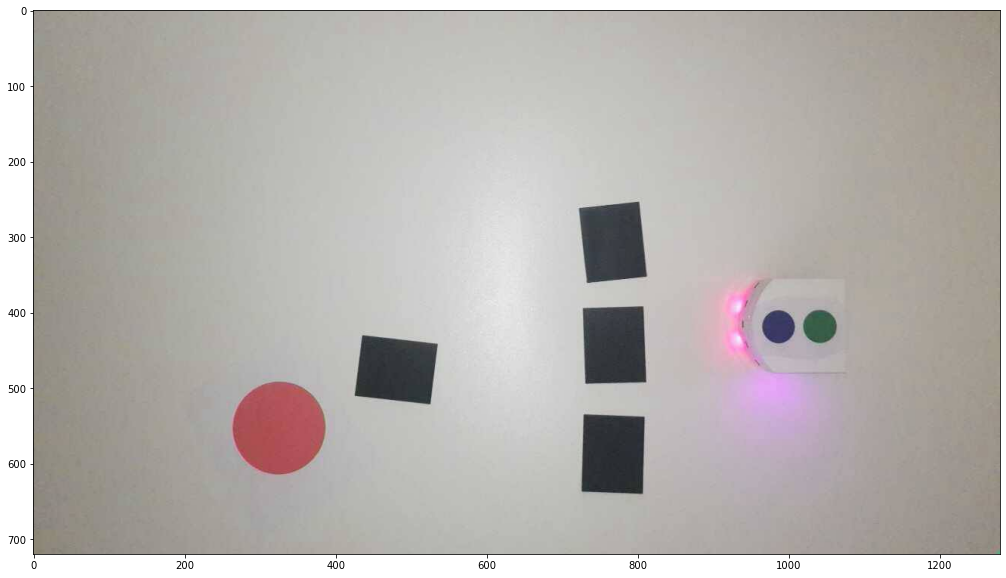

In [27]:
## %matplotlib inline
raw_frame = cv2.imread('figures/report.jpg')
#cap = vision.VideoCapture('http://192.168.13.124:8080/video') #IP adress of phone
#raw_frame = cap.read()
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(raw_frame,cv2.COLOR_BGR2RGB))
plt.show()

### Detecting the Thymio

The Thymio is detected by finding the green circle (center of the Thymio) and the blue circle (front of the Thymio). This will make it possible to determine the position of the robot in (x, y) as well as its orientation ($\theta$).<br>
In order to find the green circle, we use the HSV color model (Hue, Saturation, Value) in order to only take into consideration the color we need to detect a circle in. <br>
The function that detects the green circle, for example: 
1. Convert image to HSV and only take green channel
2. Apply hough transform on green image
3. Draw the circle in the output image, then draw a rectangle corresponding to the center of the circle
4. Return the coordinates for the center of the circle as well as an image with the circle drawn

The python implementation of the center of the thymio is below : 

In [45]:
def find_thymio_center(frame):
    """
    If present on the frame, finds the Thymio center green circle using open cv2 library and hsv color format

    :param frame: Image of the environnement obtained from the camera in format 1280:720p
    
    :return: if detected, returns the position of Thymio's center and the frame with the green circle identified
    """
    blurred_frame = cv2.GaussianBlur(frame, (7, 7), 1.5)
    # Convert image to HSV and only take green channel
    ## convert to hsv
    hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)
    mask_green = cv2.inRange(hsv, (60, 60, 60), (80, 255,255))
    ## slice the green
    imask = mask_green>0
    green = np.zeros_like(frame, np.uint8)
    green[imask] = blurred_frame[imask]
    # Apply hough transform on green image
    # Convert image to grayscale
    green_gray = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
    circles_green = cv2.HoughCircles(green_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=70, param2 = 10,
                                     minRadius = 0, maxRadius = 50)
    # ensure at least some circles were found
    output_green = frame.copy()
    if circles_green is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles_green = np.round(circles_green[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles_green:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output_green, (x, y), r, (0, 0, 255), 2)
            cv2.rectangle(output_green, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)
        robot_center_absolute = [circles_green[0][0], 720 - circles_green[0][1]]
        return robot_center_absolute, output_green
    else:
        return None, None


Here is the result we obtain by calling the function. 

Thymio center coordinates : [1041, 302]



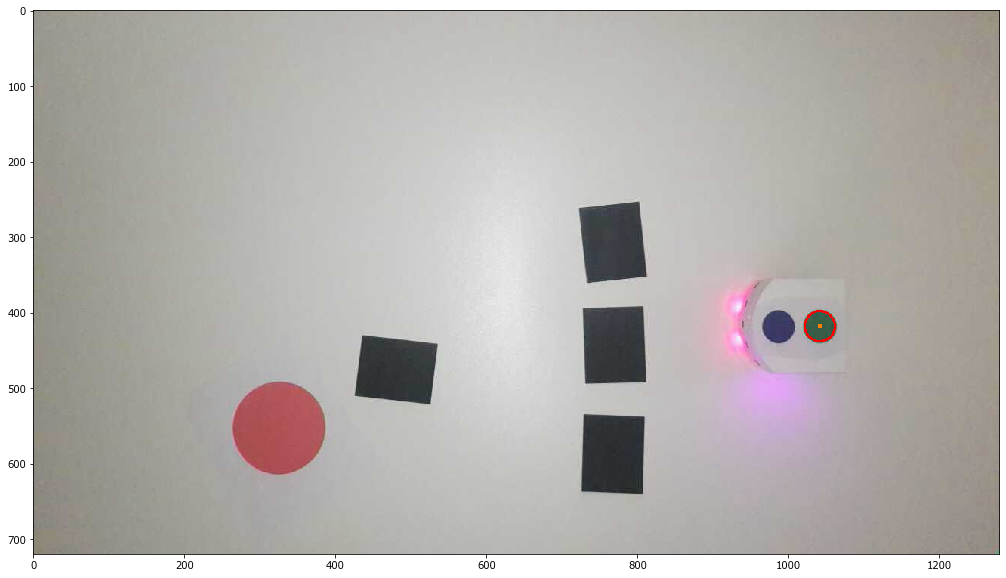

In [5]:
thymio_center, image = vision.find_thymio_center(raw_frame)
print('Thymio center coordinates : {}\n'.format(thymio_center))
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

The front of the thymio (the blue circle) is found by doing exactly the same, but using only the blue part of the image: 

Thymio front coordinates : [986, 299]



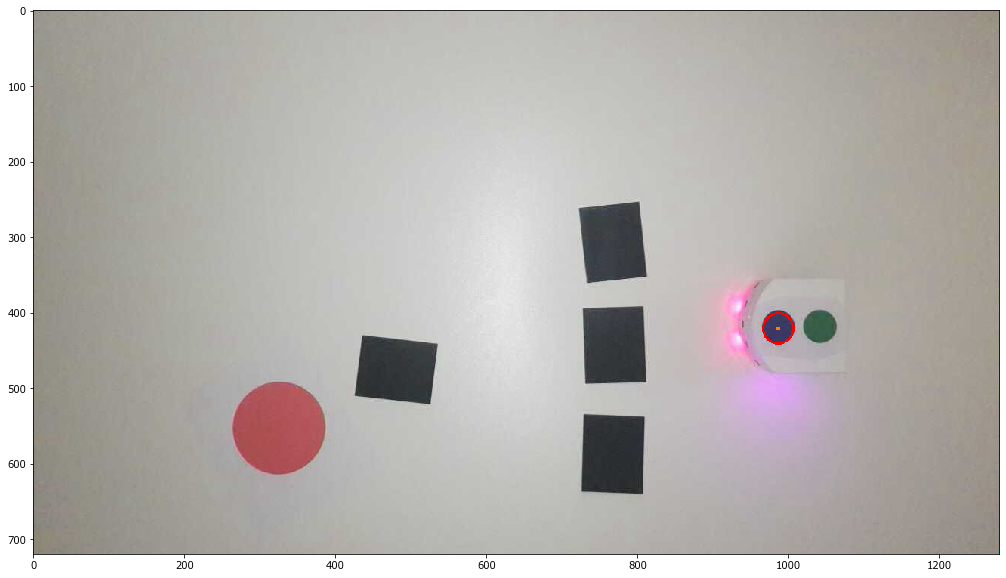

In [6]:
thymio_front, image = vision.find_thymio_front(raw_frame)
print('Thymio front coordinates : {}\n'.format(thymio_front))
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

Now that the position and orientation of the thymio is found, we can move on to detect the destination position. 

### Detecting the destination

We use the center of a big red cirlce as our destination position. This makes it simpler to detect as we already have the methodology to detect colored circles in an image. <br>
We simply apply the same algorithm used to detect the green and blue circles, but with an image only containing the red colors : 

Destination center coordinates : [325, 166]



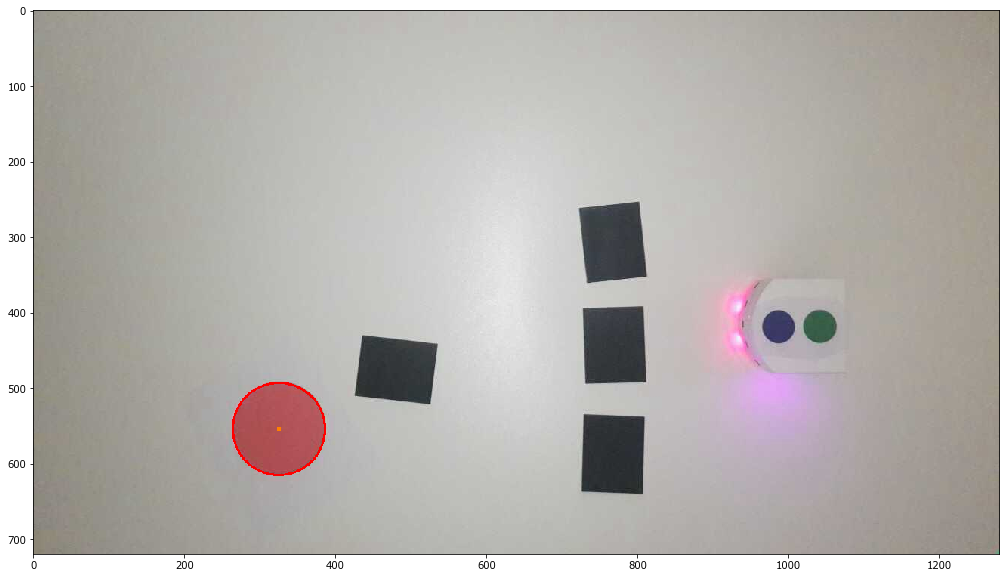

In [7]:
destination_center, image = vision.find_destination_center(raw_frame)
print('Destination center coordinates : {}\n'.format(destination_center))
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

We have now detected the Thymio as well as the destination. Let's detect the objects, which we have chosen to be thin black rectangles.

### Detecting the objects

In order to detect the objects, we will procede as follows: 

1. Convert image to HSV and only take black channel
2. Find the contours of said image
3. Find the polygons which have four edges and have an area bigger than a certain threshold
4. Draw bounding boxes around these polygons as they may not be perfect
5. Return an image with the found objects

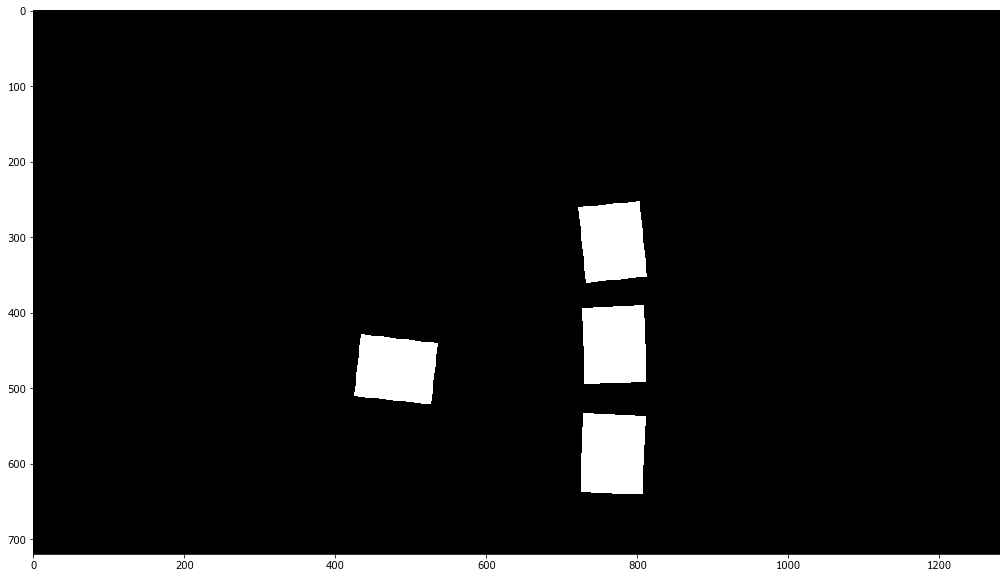

In [24]:
importlib.reload(vision)
objects = vision.find_objects(raw_frame)
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(objects,cv2.COLOR_BGR2RGB))
plt.show()

The rectangles we have found are at their original size. However, as the A-Star algorithm doesn't take into consieration the size of the robot. To solve this, we need to thicken the rectangles by the radius of the Thymio so that they don't touch while following the path.  
The steps to thicken up the objects are : 
1. Translate the contour to the origin
2. Scale each point of the contour
3. Translate back the contour to it’s original place.  

In [28]:
def scale_contour(cnt, scale):
    """
    Scale contours into bigger ones to account for the Thymio's size 
    :param cnt: contour we want to scale (found with cv2.findCountours)
    :param scale: scale we want to apply to the contour (type float)
    
    :return: scaled contour
    """
    
    #Get the centroid of the contour
    M = cv2.moments(cnt)   
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    #Translating the contour by subtracting the center with all the points
    cnt_norm = cnt - [cx, cy]
    
    #Scale each point of the contour
    cnt_scaled = cnt_norm * scale
    
    #Translate back the contour to it’s original place.
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

By applying this to the contours in the find_objects function, we obtain the following results: 

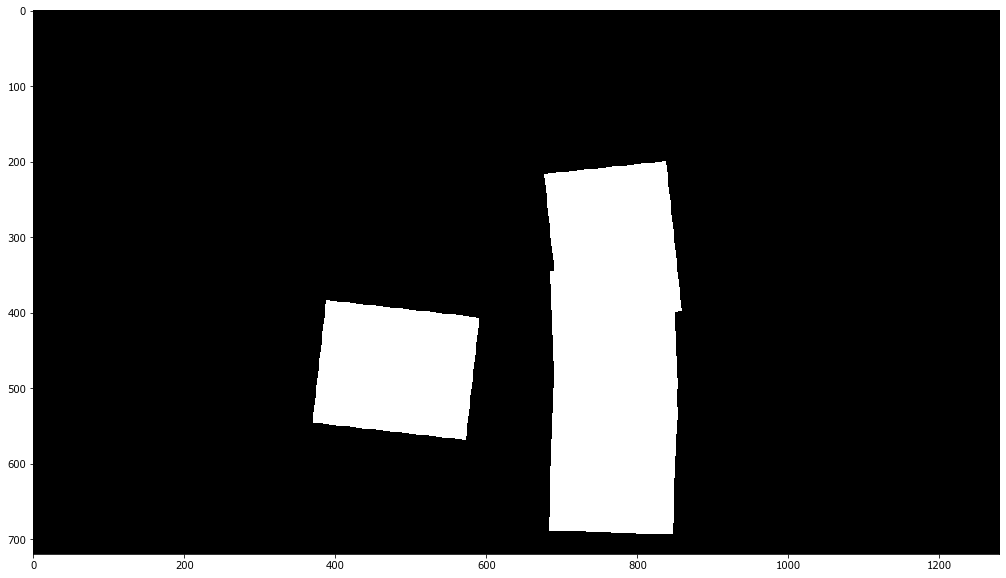

In [29]:
importlib.reload(vision)
objects = vision.find_objects(raw_frame)
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(objects,cv2.COLOR_BGR2RGB))
plt.show()

Now that we have all of the information we need to compute the path from the starting position of the robot to the destination, we can use the A-Star algorithm and implement it to the Thymio!

## II. Global Navigation

The main goal of our project is to make the Thymio move from a start position to a destination position while avoiding global objects detected by the camera and local obstacles that can be put on the path of the robot. In order to define boundaries to this project, we made one important assumption:

* The camera must be fixed, at one meter above the ground.
* The set-up environnement consists of a white board, on which the robot, the obstacles, the destination point and the local object are placed.

### A-Star path computation

We will use the A-Star algoritm provided during the exercice session in order to calculate the shortest path from the starting position to the ending position. <br>
First of all, let's display the occupancy grid that will be used to calculate the path. 

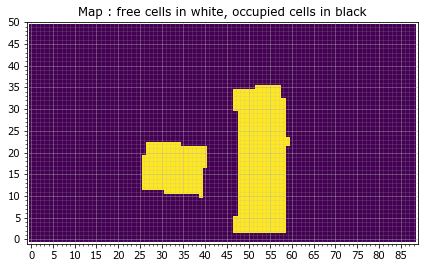

In [38]:
importlib.reload(globalNavigation)
start = (int(thymio_center[0]*0.0694), int(thymio_center[1]*0.0694))
goal = (int(destination_center[0]*0.0694), int(destination_center[1]*0.0694))

occupancy_grid, cmap = globalNavigation.display_occupancy_grid(objects)

As it can be seen in the image above, x-scale only goes until 89 pixels, and the y-scale to 50 pixels. The image also looks less precise than the original image with the objects.  
This is because we have resized the original image (1280x720) by a factor of 14.4. <br>

This makes it possible to compute the A-Star path fast, which is important for our application. <br>
Let's compute the A-Star algorithm and see the path it proposes. 

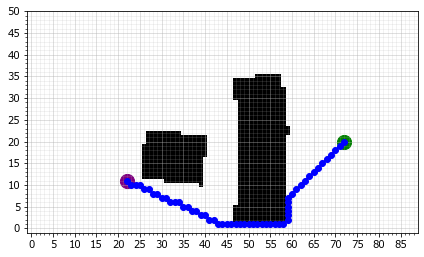

In [36]:
globalNavigation.runAstar(start, goal, utils.A_STAR_Y_AXIS_SIZE, occupancy_grid, cmap);

### Path simplification

As the Thymio's motors don't have a feedback like stepper motors, we simplify the path computed to make less turns and thus less errors. The simplified path will be a little longer than the original one, but that isn't very important as the robot takes time while turning, and that this time is not taken into account while computing the A-Star algorithm.

In order to make the Thymio follow the path computed, it needs to be calibrated to follow the path precisely with the motors. 

Below you can see the simplifier function that reduce the number of steps necessary to reach the destination.

In [ ]:
def pathSimplifier(path): #return only points to simplify path
    """
    Simplifies the complex path computed by A* algorithm into a list of checkpoint that the Thymio will have to visit to avoid obstacles

    :param path: path computed by the A* algorithm in the format [(x1,y1),(x2,y2),...]
    
    :return: list of checkpoint coordinates corresponding to the simplified path
    """
    
    index = 0
    simplePath = []
    simplePath.append(path[index])
    index = index + 1
    finalIndex = index
    while finalIndex < len(path)-1: #loops in paths points
            #print(f'Main loop')
            #print(f'Main index: {index}')
            #print(f'Main finalIndex: {finalIndex}')
        lookingFurther = 0
        index = finalIndex
        refAngle = getAbsoluteAngle(path[index],path[index+1]) 
        while index < len(path)-1:
                #print(f'Inside loop')
                #print(f'index:{index}')
            newAngle = getAbsoluteAngle(path[index], path[index+1])
            #print(abs(refAngle-newAngle))
            if abs(refAngle-newAngle) > 0.2:
                if lookingFurther < SIMP_THRESHOLD:
                    lookingFurther = lookingFurther+1
                else:
                    break
            else:
                lookingFurther = 0
                finalIndex = index+1
                if finalIndex > len(path)-1-SIMP_THRESHOLD_CLOSE:
                    finalIndex = len(path)-1
                    break
            index = index + 1
                #print(f'Inside index: {index}')
                #print(f'Inside finalIndex: {finalIndex}')
        simplePath.append(path[finalIndex])

    return simplePath

### Calibration of motors

The motors are calibrated in rotation by making the robot rotate 10 times clockwise (this was done in Aseba Studio with the code provided in Exercice Session 5). <br>

```
var counting = 0
var time = 0

timer.period[0] = 10 # milliseconds

onevent button.right # start counting
  counting = 1
  time = 0
  motor.left.target = 100
  motor.right.target = -100

onevent button.center # stop counting
  counting = 0
  motor.left.target = 0
  motor.right.target = 0

onevent timer0
  if counting == 1 then
    time = time + 1
  end
```

We found that a revolution takes 8900ms at a speed of (100, -100) for the right and left motors. <br>
After that we calibrated the move and turn. 
Using this information, we can write helper functions to make the robot go forward and turn to a specific angle more precisely.

After having computed the path, we call the function **followPath** for the globalNavigation module.  
It will give the robot instructions to turn and go forward, ultimately following the path and arriving at the destination. 
Basically, it works with the following algorithm (in pseudo-code): 
```
for every position in simplified path:
    compute angle relative angle between current position and next position
    compute distance between current position and next position
    turn until it reaches the desired angle
    go forward until it reaches the next position
```

Here is the function coded in python : 

In [43]:
def followPath(ourThymio, path):

    for index in range(len(path)-1):

        global REACHED
        REACHED = False
        print(f'path index: {index}')

        #Turns to face the next goal in path
        if index == 0:
            angleToTurn = angleDifference(ourThymio.angle, angleTwoPoints(path[index+1],ourThymio.getCenter()))
            print(f'angleToTurn: {np.rad2deg(angleToTurn)}')
            turnAngle(angleToTurn, ourThymio)
        else:
            angleToTurn = angleCalculatorPath(path[index],path[index-1],path[index+1])
            print(f'angleToTurn: {np.rad2deg(angleToTurn)}')
            turnAngle(angleToTurn, ourThymio)

        #Goes forward towards next goal, kalman and local avoidance is active
        #ourThymio.stopKalmanFlag.clear()
        #kThread = kalman.kalmanThread(ourThymio)

        distance = distanceCalculator(path[index], path[index+1])
        goForward(distance, ourThymio)

        #kThread.start()

        while not REACHED:
            #check if collision
            wentInLocal = localNavigation.localCheck(ourThymio)
            #check if local nav ended
            if wentInLocal:
                ourThymio.inLocal = False
                return False
            # kalman is executed automatically every DT in kThread

    return True

## III. Local Navigation

At this point, the robot can follow the computed global path, going around the objects, avoiding them while aiming to reach the destination red circle. One specification of our project is that at in time, an obstacle can be placed on the Thymio's path. To avoid it and continue its journey to its final destination, we implemented an adapted local avoidance algorithm based on the Wall Following concept.

For the sake of feasability and to obtain consistent and interesting behaviour, we made assumptions regarding the obstacle shape and its possible positions:

* The obstacle is a rectangle (squares included) and has a sufficient width to be detected by Thymio's proximity sensors.
* If the local obstacle is placed close to an object, there must be enough space to overtake the obstacle either on the left or the right side of the obstacle.
* Consequently, a local obstacle must not block the path of the robot and create a bottleneck, preventing the Thymio to reach the destination goal.


### Switching between global and local navigation 

As expected, one of the most challenging part was to make the link between the global navigation and the local avoidance algorithms. The robot must not mix the two modes and should have clear separated and independant parts.

In the global navigation, there are two threads that can be active at the same time. First the forward displacements of the Thymio (between two global checkpoints) is managed with a timer, computed with the distance to travel and the constant speed of the robot. The timer is set when the Thymio reaches a point computed by the **_pathSimplifier()_** function, and a stop function is called when the robot reach the next checkpoint and the timer goes down to zero. We also start a thread for the Kalman filter that measures the position of the robot, computes the predicted next robot state and updates the current state whil controlling the motors to adjust the trajectory of the Thymio.



Here you can find the **_localCheck()_** function that get the proximity sensors values to determine if there is an object in front of the robot:

In [22]:
def localCheck(ourThymio): #check if object detected to enter loccal nav
    """
    Indicates if the Thymio locally detects an obstacle with its proximity sensors' values

    :param ourThymio: object of class virtualThymio representing our robot, gathering state information and class methods
    
    :return: boolean indicating whether the Thymio detects an local obstacle 
    """

    prox_values = get_prox_values(ourThymio)
    if sum(prox_values) > DIST_THRES:
        print('PROX VALUES')
        print(prox_values)
        ourThymio.inLocal = True
        ourThymio.stopKalmanFlag.set()        
        navigate(ourThymio)
        return True
    
    else:
        return False

When the Thymio "sees" an obsatcle, meaning when the proximity sensors react to an obstacle, the flags _inLocal_ and _stopKalmanFlag_ of the object _ourThymio_ of class **_virtualThymio_** are set to inform the program and the other part of the code (Kalman and global navogation) that the robot entered the local mode. 
Thus, the ending and stoping tasks of the global timer and the motor control of the Kalman filter, by checking those flags, won't interrupt the local avoidance algorithm.
    
    

### Local Navigation Algorithm



If the proximity sensors detect something in front of them, then the **_navigate()_** function is used to avoid the obstacle. In order to optimise the trajectory when overtaking the obstacle, we look at the value of the 5 sensors to find out where the object is located compared to the robot. It will then decide whether to go on the right side or on the left side to take the shortest path. The function can be found in the python file __localNavigation.py__. It is called each time the thymio detects a new object on its path.


We chose a wall following algorithm for the local avoidance. It works as follows:

* When the robot detects an object with the proximity sensors, it finds on which side to overtake it;
* The rotation direction is controlled by the variable _rot_angle_, wich is set to -90° tu turn on the right side when seeing the object for the first time, and to its opposite if turning on the left side is a better option;
* After turning 90° on the side, it regularly turns to look if the obstacle is still next to it, if so, the Thymio continue moving on the side until it doesn't see the obstacle anymore;
* When the robot can not see anything on the side, it rotates in its original orientation and continue moving forward to overtake the obstacle;
* Along the path it continues to check where is the obstacle;
* At the end, when the obstacle is not in sight anymore, the robot exit the local navigation algorithm and reinitiates the global navigation by computing a new path from the new position of the Thymio.


You can see below a gif of the local avoidance when the Thymio is facing its own box. In our project, the main obstacle we used was a Rubik's cube but the local avoidance works with any rectangle object.

![SegmentLocal](figures/local.gif "segment")

## V. Filtering

Our Kalman filtering happens when the Thymio robot goes forward on a straight line. As mentionned above, in the global navigation, the Thymio gets a list of points. It first rotates on itself to face the next point, then it moves straight to that point.
There is no Kalman filter for the rotation part. This is because we found that it was sufficient in terms of accuracy because our filter takes into account the orientation of the robot when it is moving.

We used the FilterPy library to implement our Kalman Filter. This library does nothing special expect saving us time with matrix multiplications. Indeed it checks for us that the matrices have the right size and provides simple functions to make the code more readable.

The following model for our model was chosen. Naming convention follows FilterPy which is slightly different from class notation but the structure is the same.
We chose the following state predictor function.
$$\bar x = F\cdot x + B\cdot u$$
Which is
$$ \begin{bmatrix}\bar x \\\bar y \\\bar v_x \\\bar v_y\end{bmatrix} = 
\begin{bmatrix} 1 & 0 & dt & 0 \\ 0 & 1 & 0 & dt \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot
\begin{bmatrix}\ x \\\ y \\\ v_x \\\ v_y\end{bmatrix} +
\begin{bmatrix} dt & 0 \\ 0 & dt \\ 1 & 0\\ 0 & 1\end{bmatrix} \cdot
\begin{bmatrix} \Delta v_{x_{control}} \\ \Delta v_{y_{control}} \end{bmatrix}$$

We can see that we have an control input matrix u. This is how of the prediction of the next state with the Kalman filter will influence the motors of the robot. We are tracking two velocities in the matrices yet this is not really what we are doing in the code. We use a trick where we are actually tracking the orientation of the robot and we translate it to x and y velocities to avoid having triginometric operations in the matrices. This is possible because we assume a **constant velocity model**. Once we get the prediction we measure how much the robot needs to 'tilt' to get back on the right track. Let's give an example, suppose our robot has the x_vel relatively close to the measured value yet the y_vel is a not as close. We compute a ratio and decide if the robot needs to move to the left or to the right. If we need it to move to the right we send instructions to increase the base motor speed by the computed ratio and decrease the right motor speed by that same ratio.

Then we have the residual equation:
$$y = z - H\cdot\bar x$$

With an identity measurement matrix H because our measurements are given in the same units.

$$H = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

Our covariance matrix R for measurement noise is the following. The units are in scared pixels and were estimated by taking 50 frames of a still Thymio, getting its position and orientation and computing the variance. Then we repeated the experience 5 times to account for different lighting reflections and angles and got the values by averaging the results.
An avid reader will notice that the non-diagonal terms are null which implies that the measured "sensors" (here position and velocity) are not correlated. This is obviously not true because they all come a frame taken from the camera yet we found that it was not significant enough to be included here. Our results are already good enough.

$$R = \begin{bmatrix} 5 & 0 & 0 & 0 \\ 0 & 5 & 0 & 0 \\ 0 & 0 & 3 & 0 \\ 0 & 0 & 0 & 3 \end{bmatrix}$$

To measure our Q process noise matrix we use the following approach. We make the Thymio run in a straight line for 30 seconds along the x-axis heading towards zero and take a sample of its perceived position and absolute angle at every second. For the position, the thymio was supposed to move in a straight line yet when we plot it we see that this is the case for the x position because of there is supposed to be a lot of change yet for the y-axis things look different. The plot should not be horizontal as it is almost impossible to align the Thymio with the axis yet the points measured should in theory be linear. We assume a mean straight line and compute the variance of the points measured to get the value for our matrix.

$$\sigma _{x} ^2=\sigma _{y} ^2=1.3$$
<center><img src='figures/ypos.png' style="width: 500px;"></center>

For the angle, we know that when the Thymio is going straight the angle is not supposed to change, so we look at the variation of the angle and then transform is to angular speeds because of our constant velocity model. 

$$\sigma _{vel_x} ^2=\sigma _{vel_y} ^2=\text{utils.FORWARDCONSTANT}\cdot cos(\sigma _{\theta} ^2)=3.5$$
<center><img src='figures/angle.png' style="width: 500px;"></center>

Which gives us the following Q process noise matrix. We assume no covariance to make things easier.

$$Q = \begin{bmatrix} \sigma _{x} ^2 & 0 & 0 & 0 \\ 0 & \sigma _{y} ^2 & 0 & 0 \\ 0 & 0 & \sigma _{vel_x} ^2 & 0 \\ 0 & 0 & 0 & \sigma _{vel_y} ^2 \end{bmatrix} =\begin{bmatrix} 1.3 & 0 & 0 & 0 \\ 0 & 1.3 & 0 & 0 \\ 0 & 0 & 3.5 & 0 \\ 0 & 0 & 0 & 3.5 \end{bmatrix}$$

## VI. Loop to run the project

In [ ]:
reachedEnd = False
destinationCenter = None

while not reachedEnd:
    
    ourThymio = utils.virtualThymio(cap,th)
    path, destinationCenter = utils.analyze(ourThymio, destinationCenter)
    print(path)
    reachedEnd = globalNavigation.followPath(ourThymio, path)

## VII. Small Demo

![SegmentLocal](figures/demo.gif "segment")